# Three Classes Classification using Genomic Data

In [2]:
import os
os.chdir("..")

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from helpers import load_config
import matplotlib.pyplot as plt
import seaborn as sns

configs = load_config(os.path.join("configs", "configs.yaml"))
study_path = configs["STORAGE_DIR_STUDY2"]

Continue from 04_genomic_multiclass_2.ipynb

In [4]:
one_hot_df = pd.read_csv(
    os.path.join(study_path, "all_samples_40_genes_one_hot.csv")
)
one_hot_df.head(2)

,Tumor_Sample_Barcode,APC,BAX,BMPR1A,BRAF,DCC,EGFR,ENG,EPCAM,ERBB2,...,PIK3CD,POLD1,POLE,PTEN,RNF43,SCG5,SMAD4,STK11,TGFBR2,TP53
0,TCGA-3L-AA1B-01,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-4N-A93T-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Reproduce steps in 04_genomic_data_analysis.ipynb but with new pathological_df_v2.csv which contains 86 instead of 63 rows.


In [5]:
pathological_df = pd.read_csv(
    os.path.join(study_path, "pathological_df_v2.csv")
)
print(f"Shape of new pathological df:{pathological_df.shape}")
pathological_df.head(2)

Shape of new pathological df:(88, 18)


,PATIENT_ID,AGE,SEX,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,PERSON_NEOPLASM_CANCER_STATUS,PRIOR_DX,RADIATION_THERAPY,WEIGHT,PFS_MONTHS,GENETIC_ANCESTRY_LABEL,SAMPLE_ID,ONCOTREE_CODE,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS
0,TCGA-5M-AAT6,40.0,Female,M1A,N2B,T4A,With Tumor,No,No,99.1,7.199921,AFR,TCGA-5M-AAT6-01,COAD,3.0,0.6600,20.58,62.166667
1,TCGA-5M-AATE,76.0,Male,M0,N0,T3,With Tumor,No,No,75.4,26.629845,,TCGA-5M-AATE-01,COAD,20.0,0.3252,0.47,3.800000


In [6]:
one_hot_df = one_hot_df.rename(
    columns={"Tumor_Sample_Barcode": "SAMPLE_ID"}
)

one_hot_df2 = pd.merge(pathological_df["SAMPLE_ID"], one_hot_df, on='SAMPLE_ID', how="inner")

In [7]:
one_hot_df2.drop("SAMPLE_ID", axis=1).sum().sort_values(ascending=False)

APC       68
TP53      62
KRAS      38
PIK3CA    23
SMAD4     11
POLE       8
DCC        8
NTRK2      7
RNF43      7
BRAF       6
POLD1      6
NRAS       6
PTEN       5
ERBB2      4
MSH2       4
MLH1       3
ENG        3
TGFBR2     3
MSH6       2
NTRK1      2
NTRK3      2
PIK3CD     1
NTHL1      1
PIK3CB     1
MUTYH      1
GREM1      1
EPCAM      1
BAX        0
MSH3       0
SCG5       0
STK11      0
EGFR       0
BMPR1A     0
dtype: int64

Rule of thumb: ideal no of columns = rows/5 to rows/6 = 14 to 17 columns    

Using first 13 columns based on the frequency of values(>=5).

In [8]:
mutation_X = one_hot_df2[["SAMPLE_ID", "APC", "TP53", "KRAS", "PIK3CA", "SMAD4", "POLE", "DCC", "NTRK2", "POLD1", "NRAS", "RNF43", "PTEN", "BRAF"]]

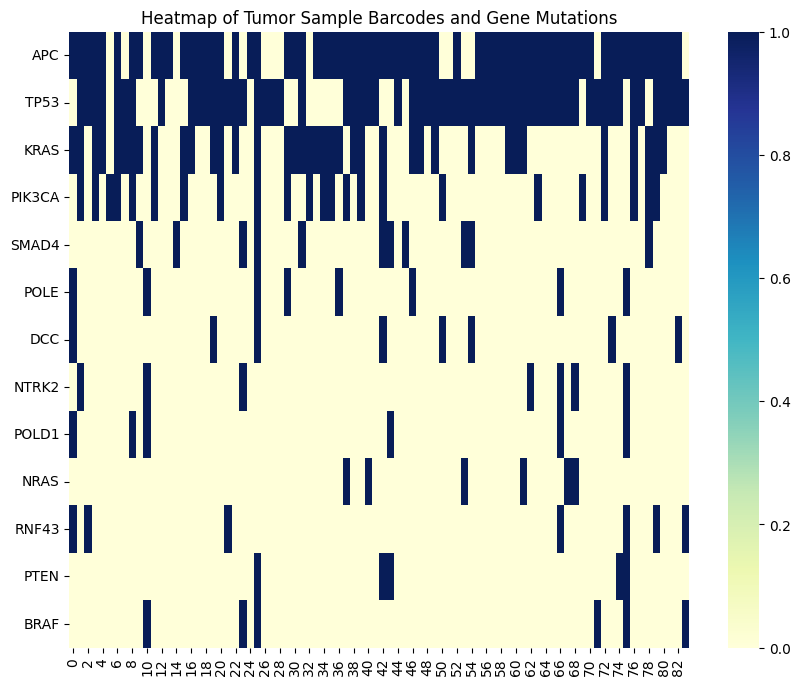

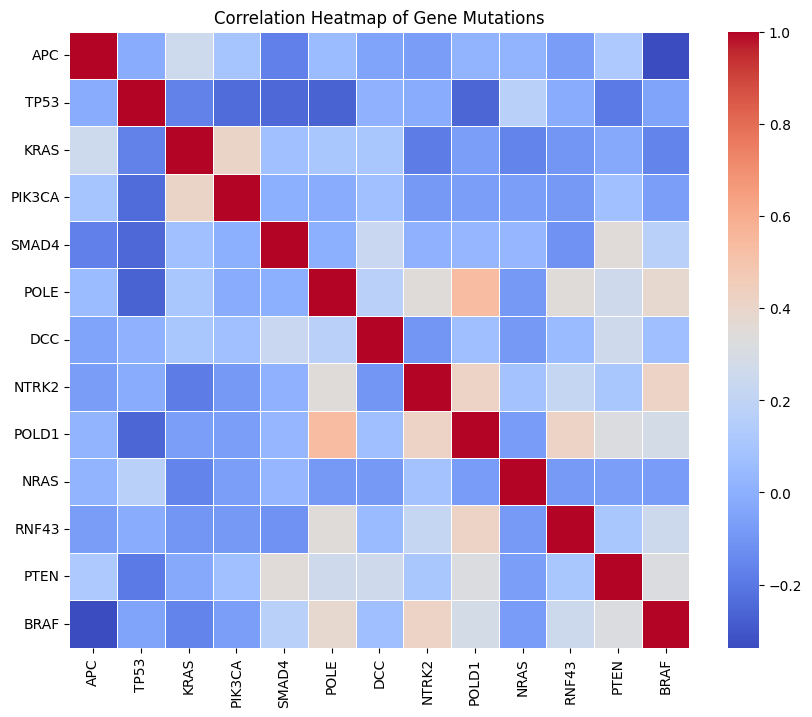

In [9]:
subset_1 = mutation_X.drop("SAMPLE_ID", axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(subset_1.T, cmap="YlGnBu", cbar=True)
plt.title('Heatmap of Tumor Sample Barcodes and Gene Mutations')
plt.show()


corr_matrix = subset_1.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap of Gene Mutations')
plt.show()


## Prepare y for multiclass classification

In [10]:
df = pd.merge(pathological_df[["SAMPLE_ID", "PFS_MONTHS"]], mutation_X, on='SAMPLE_ID', how="inner")
df.head(2)

,SAMPLE_ID,PFS_MONTHS,APC,TP53,KRAS,PIK3CA,SMAD4,POLE,DCC,NTRK2,POLD1,NRAS,RNF43,PTEN,BRAF
0,TCGA-5M-AAT6-01,7.199921,1,0,1,0,0,1,1,0,1,0,1,0,0
1,TCGA-5M-AATE-01,26.629845,1,1,1,1,0,0,0,1,0,0,0,0,0


In [11]:
def categorize_pfs(months):
    """categorize pfs into 3 classes at thresholds 12, 36, 36+"""
    if months <= 12:
        return 0
    elif 12 < months <= 36:
        return 1
    else:
        return 2


df['y'] = df['PFS_MONTHS'].apply(categorize_pfs)
df.head(2)

,SAMPLE_ID,PFS_MONTHS,APC,TP53,KRAS,PIK3CA,SMAD4,POLE,DCC,NTRK2,POLD1,NRAS,RNF43,PTEN,BRAF,y
0,TCGA-5M-AAT6-01,7.199921,1,0,1,0,0,1,1,0,1,0,1,0,0,0
1,TCGA-5M-AATE-01,26.629845,1,1,1,1,0,0,0,1,0,0,0,0,0,1


/var/folders/_0/qrjsyj4n0r951n63lt8qdzrc0000gn/T/ipykernel_88501/1661662862.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


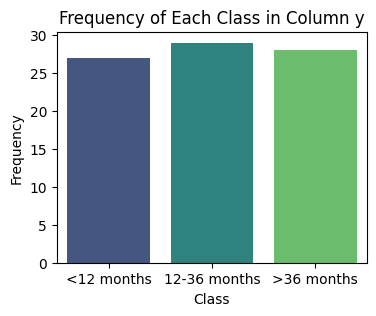

In [12]:
# Calculate the frequency of each class in column 'y'
class_counts = df['y'].value_counts().sort_index()

# Plot the frequency using a bar plot
plt.figure(figsize=(4, 3))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class in Column y')
plt.xticks([0, 1, 2], ['<12 months', '12-36 months', '>36 months'])
plt.show()


### Perform classification

In [13]:
X = df.drop(["SAMPLE_ID", "PFS_MONTHS", "y"], axis=1)
y = df.y
X.shape, y.shape

((84, 13), (84,))

In [14]:
from colorectal_adenocarcinoma.model_evaluators import multiclass_classification, plot_feature_importance_plot_using_rf

In [15]:
predictions = multiclass_classification(X, y, binary_classification=False)
pd.DataFrame(predictions).T.sort_values("F1-Score", ascending=False)


,F1-Score,Recall,Accuracy,Precision
Decision Tree,0.535585,0.534498,0.535714,0.545455
XGBoost,0.523734,0.522532,0.523810,0.539432
Linear SVM,0.510614,0.511038,0.511905,0.515961
Gradient Boosting,0.498384,0.499954,0.500000,0.511442
Logistic Regression,0.494840,0.497841,0.500000,0.499501
Random Forest,0.479498,0.477027,0.476190,0.484623
Support Vector Machine,0.451751,0.451484,0.452381,0.454761
K-Nearest Neighbors,0.348157,0.390348,0.392857,0.351683


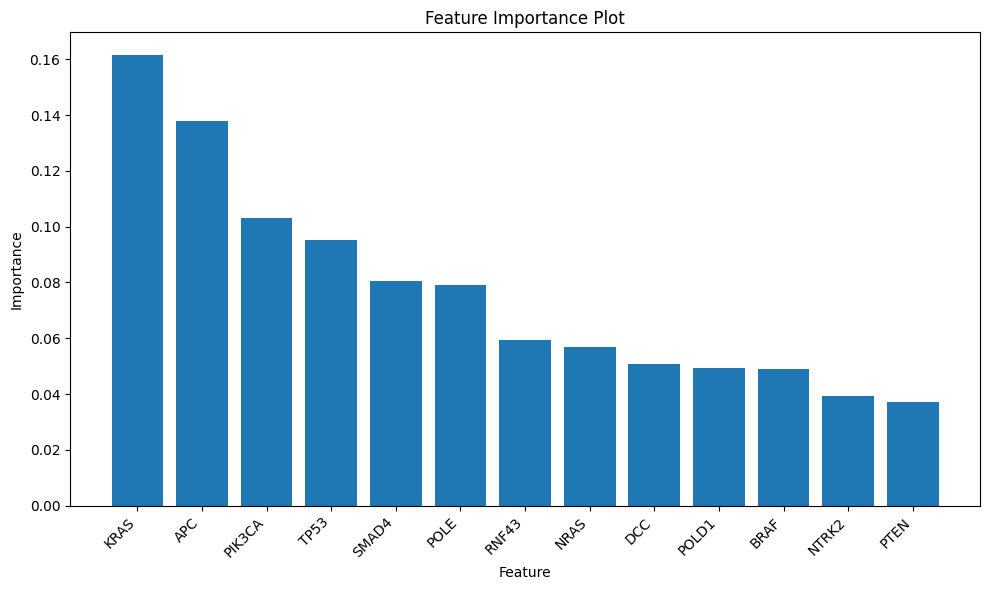

In [16]:
plot_feature_importance_plot_using_rf(X, y)